# GWASmetric (withHom Example)
There are number of ways to measure association power of a SNP with respect to a binary phenotype. 

In [1]:
import csv
import numpy as np
import pandas as pd

## Initialise Hail v0.2
Try using [VariantSpark on the AWS MarketPlace](https://aws.amazon.com/marketplace/pp/AEHRC-VariantSpark-Notebook/B07YVND4TD) which provide you a Jupyter notebook with VariantSpark and Hail v0.2 installed and ready to use.

See the step-by-step instruction [here](https://drive.google.com/file/d/1pD40H1wseP8RhrV6XnkkyvZMqxqkN_N5/view?usp=sharing)

Hail is configured to read/write from/to AWS S3

In [2]:
import os
from pyspark import SparkContext
sc = SparkContext()
import hail as hl
import varspark.hail as vshl
vshl.init(sc=sc)

using variant-spark jar at '/home/hadoop/biospark/lib/python3.6/site-packages/varspark/jars/variant-spark_2.11-0.3.0-SNAPSHOT-all.jar'
using hail jar at '/home/hadoop/biospark/lib/python3.6/site-packages/hail/hail-all-spark.jar'
using hail jar at /home/hadoop/biospark/lib/python3.6/site-packages/hail/hail-all-spark.jar
Running on Apache Spark version 2.4.4
SparkUI available at http://ip-172-31-7-156.ap-southeast-2.compute.internal:4041
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.16-6da0d3571629
LOGGING: writing to /home/hadoop/hail-20200716-0416-0.2.16-6da0d3571629.log


# Initialize Plink
If you dont have a plink on your machine uncomment below cell to downlaod it (no installation is requiered)

This cell download plink for a 64bit linux operating system and extract it in the current directory.

Change plink download path if you use a different operating system.  

In case you already have plink on your machine replace "./plink" with "plink" in all other cell. 

In [3]:
# %%sh
# wget http://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20200616.zip &> temp
# unzip plink_linux_x86_64_20200616.zip

# Simulation Parameter
in our setup, Hail read/write data from/to AWS S3 storage. If this is not yor setup you should manually change part of this notebook. The easeiest way is to use [VariantSpark on the AWS MarketPlace](https://aws.amazon.com/marketplace/pp/AEHRC-VariantSpark-Notebook/B07YVND4TD) described above.

Note that this notebook also use the local storage and write some files.

| step | noHom=True | noHom=False |
|:----:|:----------:|:-----------:|
|  0.5 |          9 |          36 |
|  0.1 |        121 |        4356 |
| 0.05 |        441 |       53361 |
| 0.01 |      10201 |    26532801 |

In [4]:
numCase=5000 # total number of cases
numCtrl=5000 # total number of controls
step=0.07    # Granuality of the simulation, more variants are simulated with lower step (0<step<1)
             # For the number of simulated variants see above table

# S3 path where all files are stored.
s3="s3://csiro-tb/home/bay041/GWASmetric/"

# Output file prefix
ofn="withHom"

# noHom=True keep the number of Homozygeour Alternate Genotype (1/1) 0.
# So that each SNP can take only 2 values 0/0 or 0/1
# This is simpler case where you can decrease the step to a smaller value
noHom=False


# Init Bash command
Write the ofn and s3 parameters to the file to be read by bash (%%sh) cells.

Why we don't use python subprocess? That's a good question! :-)

In [5]:
with open('ofn', 'w') as file:
    file.write(ofn)
with open('s3', 'w') as file:
    file.write(s3)

# Set Purity
These functions compute the set purity using Gini and Entropy. Set purity is simply 1-(set impurity).

Asume A$$ and B represent the number of cases and controls in a set where T=A+B is the number of all samples in the set. Then PA and PB represent the probability of cases and controls.

$$P_A=\frac{A}{T}$$

$$P_B=\frac{B}{T}$$

$$GiniPurity={P_A}^2+{P_B}^2$$

$$EntropyPurity=1-(P_A\times \log_2(P_A) + P_B\times \log_2(P_B))$$

While entropy range between 0 and 1, Gini range from 0.5 to 1. Note that if there are more than two clasess (case, control) the mimumum Gini would be smaller. 


In [6]:
def GiniPurity(A, B):
    T=A+B
    GP = 0
    if T:
        PA = A/T
        PB = B/T
        GP = (PA**2)+(PB**2)
    return GP

def EntropyPurity(A, B):
    T=A+B
    EP = 0
    if T:
        PA = A/T
        PB = B/T
        EP = 1
        EP += (PA*np.log2(PA)) if PA else 0
        EP += (PB*np.log2(PB)) if PB else 0
    return EP

#### Test Code
# A=10
# for B in range(0,11):
#     print(GiniPurity(A,B), EntropyPurity(A,B))

# Information Gained (IG)
When a variable splits a set into multiple subsets, the information gained is the difference between weither average purity of subsets and the purity of the parent set. In the average, the weight is the fraction of samples in the subset compared to the parent set.

In case of a SNP, the parent set is all of the samples (all cases and all controls) which is divided into three groups base on their genotype for the given SNP (0/0, 0/1, 1/1) or (Ref, Het, Hom).

In [7]:
# IG: Information Gained
def GiniIG(ParentSetPurity, CaseRef, CaseHet, CaseHom, CtrlRef, CtrlHet, CtrlHom):
    total = float(CaseRef + CaseHet + CaseHom + CtrlRef + CtrlHet + CtrlHom)
    InformationGained = 0
    if total:
        ######         Set Purity                  Weight
        Ref = GiniPurity(CaseRef, CtrlRef) * ((CaseRef + CtrlRef) / total)
        Het = GiniPurity(CaseHet, CtrlHet) * ((CaseHet + CtrlHet) / total)
        Hom = GiniPurity(CaseHom, CtrlHom) * ((CaseHom + CtrlHom) / total)
        WeightedAverageSetPurity = Ref + Het + Hom
        InformationGained = WeightedAverageSetPurity - ParentSetPurity
    return InformationGained


def EntropyIG(ParentSetPurity, CaseRef, CaseHet, CaseHom, CtrlRef, CtrlHet, CtrlHom):
    total = float(CaseRef + CaseHet + CaseHom + CtrlRef + CtrlHet + CtrlHom)
    InformationGained = 0
    if total:
        ######         Set Purity                  Weight
        Ref = EntropyPurity(CaseRef, CtrlRef) * ((CaseRef + CtrlRef) / total)
        Het = EntropyPurity(CaseHet, CtrlHet) * ((CaseHet + CtrlHet) / total)
        Hom = EntropyPurity(CaseHom, CtrlHom) * ((CaseHom + CtrlHom) / total)
        WeightedAverageSetPurity = Ref + Het + Hom
        InformationGained = WeightedAverageSetPurity - ParentSetPurity
    return InformationGained

### Simple test for information gaine function
# print(GiniIG   (0.5, 3, 5, 2, 7, 2, 1))
# print(EntropyIG(0.0, 3, 5, 2, 7, 2, 1))
# print("==============================")
# print(GiniIG   (0.5, 8, 1, 1, 7, 2, 1))
# print(EntropyIG(0.0, 8, 1, 1, 7, 2, 1))
# print("==============================")
# print(GiniIG   (0.5, 1, 1, 8, 7, 2, 1))
# print(EntropyIG(0.0, 1, 1, 8, 7, 2, 1))
# print("==============================")

# SNP simulation
## Also compute Gini and Entropy Information Gained for SNPs
All different possibility of the contingency table (given number of cases and controls) are considered and the corresponding SNP genotype is produced for population of cases and controls.

The contingency table is described below and the nested loop in the function generate all possible value with granuality of the step.

|  Genotype |   Case  |   Ctrl  |
|:---------:|:-------:|:-------:|
| 0/0 (Ref) | refCase | refCtrl |
| 0/1 (Het) | hetCase | hetCtrl |
| 1/1 (Hom) | homCase | homCtrl |

SimulateSNPs_noHom consider situation where homCase and homCtrl are always 0.

For the below contingency table, it does not matter the genotype are produced in formA, formB, or any other form, the association power should remains the same (i.e. the order of sample in the input data does not affect association power). Note that hear we consider individual SNP association power and does not consider any covariate.

|  Genotype | Case | Ctrl |
|:---------:|:----:|:----:|
| 0/0 (Ref) |   3  |   1  |
| 0/1 (Het) |   0  |   2  |
| 1/1 (Hom) |   1  |   1  |

 | Form | case1 | case2 | case3 | case4 | ctrl1 | ctrl2 | ctrl3 | ctrl4 |
|------|-------|-------|-------|-------|-------|-------|-------|-------|
| A    | 0/0   | 0/0   | 0/0   | 1/1   | 0/0   | 0/1   | 0/1   | 1/1   |
| B    | 0/0   | 0/1   | 0/0   | 0/0   | 0/1   | 1/1   | 0/0   | 0/1   |

**Hardy-Weinberg is not considered in this simulation**

In [8]:
def SimulateSNPs(writer, giniParentSetPurity, entropyParentSetPurity, numCase, numCtrl, step):
    
    stepCtrl = int(numCase * step)
    stepCase = int(numCtrl * step)
    
    
    pos=0
    for refCase in range(0, numCase+1, stepCase):  
        for hetCase in range(0, (numCase-refCase)+1, stepCase):
            homCase = numCase - (refCase + hetCase)
            for refCtrl in range(0, numCtrl+1, stepCtrl):
                for hetCtrl in range(0, (numCtrl-refCtrl)+1, stepCtrl):
                    homCtrl = numCtrl - (refCtrl + hetCtrl)
                    
                    pos+=1
                    
                    giniIG    = GiniIG   (giniParentSetPurity   , refCase, hetCase, homCase, refCtrl, hetCtrl, homCtrl)
                    entropyIG = EntropyIG(entropyParentSetPurity, refCase, hetCase, homCase, refCtrl, hetCtrl, homCtrl)
                    
                    snpID  =     str(refCase)
                    snpID += "#"+str(hetCase)
                    snpID += "#"+str(homCase)
                    snpID += "#"+str(refCtrl)
                    snpID += "#"+str(hetCtrl)
                    snpID += "#"+str(homCtrl)
                    snpID += "#"+str(giniIG)
                    snpID += "#"+str(entropyIG)
                    
                    genotype = ["1", pos, snpID, "A", "C", ".", ".", ".", "GT"]
                    genotype += ["0/0"]*refCtrl
                    genotype += ["0/1"]*hetCtrl
                    genotype += ["1/1"]*homCtrl
                    genotype += ["0/0"]*refCase
                    genotype += ["0/1"]*hetCase
                    genotype += ["1/1"]*homCase
                    writer.writerow(genotype)
    print("SNPs simulated: ", pos)

def SimulateSNPs_noHom(writer, giniParentSetPurity, entropyParentSetPurity, numCase, numCtrl, step):
    
    stepCtrl = int(numCase * step)
    stepCase = int(numCtrl * step)
    
    
    pos=0
    for refCase in range(0, numCase+1, stepCase):  
        hetCase = numCase-refCase
        homCase = 0
        for refCtrl in range(0, numCtrl+1, stepCtrl):
            hetCtrl = numCtrl-refCtrl
            homCtrl = 0

            pos+=1

            giniIG    = GiniIG   (giniParentSetPurity   , refCase, hetCase, homCase, refCtrl, hetCtrl, homCtrl)
            entropyIG = EntropyIG(entropyParentSetPurity, refCase, hetCase, homCase, refCtrl, hetCtrl, homCtrl)

            snpID  =     str(refCase)
            snpID += "#"+str(hetCase)
            snpID += "#"+str(homCase)
            snpID += "#"+str(refCtrl)
            snpID += "#"+str(hetCtrl)
            snpID += "#"+str(homCtrl)
            snpID += "#"+str(giniIG)
            snpID += "#"+str(entropyIG)

            genotype = ["1", pos, snpID, "A", "C", ".", ".", ".", "GT"]
            genotype += ["0/0"]*refCtrl
            genotype += ["0/1"]*hetCtrl
            genotype += ["1/1"]*homCtrl
            genotype += ["0/0"]*refCase
            genotype += ["0/1"]*hetCase
            genotype += ["1/1"]*homCase
            writer.writerow(genotype)
    print("SNPs simulated: ", pos)


# VCF File Simulation
To compute association power using plink, Hail and other GWAS software
we cannot directly input the contingency table.
Thus we generate VCF file where the SNP genotype reflect the contingency table that we produce.

In [9]:
def Simulate(ofn="test", numCase=10, numCtrl=10, step=0.1):
    
    # Compute Parent set purity
    giniParentSetPurity    = GiniPurity(numCase, numCtrl)
    entropyParentSetPurity = EntropyPurity(numCase, numCtrl)
    print("Gini    Parent Set Purity", giniParentSetPurity)
    print("Entropy Parent Set Purity", entropyParentSetPurity)

    # Simulte VCF file
    with open(ofn+'.vcf','w') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t', quotechar=' ', quoting=csv.QUOTE_MINIMAL)

        writer.writerow(["##fileformat=VCFv4.2"])
        writer.writerow(['##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">'])
        header=["#CHROM","POS","ID","REF","ALT","QUAL","FILTER","INFO","FORMAT"]
        for ctrl in range(1,numCtrl+1):
            header.append("ctrl"+str(ctrl))
        for case in range(1,numCase+1):
            header.append("case"+str(case))
        writer.writerow(header)

        if noHom:
            SimulateSNPs_noHom(writer, giniParentSetPurity, entropyParentSetPurity, numCase, numCtrl, step)
        else:
            SimulateSNPs(writer, giniParentSetPurity, entropyParentSetPurity, numCase, numCtrl, step)
    
    # Simulate phenotype file compatible with plink --pheno
    with open(ofn+'.pheno','w') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t', quotechar=' ', quoting=csv.QUOTE_MINIMAL)
        for ctrl in range(1,numCtrl+1):
            line = ["ctrl"+str(ctrl), "ctrl"+str(ctrl), 1]
            writer.writerow(line)
        for case in range(1,numCase+1):
            line = ["case"+str(case), "case"+str(case), 2]
            writer.writerow(line)

### Perform the Simulation

In [10]:
Simulate(ofn=ofn, numCase=numCase, numCtrl=numCtrl, step=step)

Gini    Parent Set Purity 0.5
Entropy Parent Set Purity 0.0
SNPs simulated:  14400


# Plink
We use plink to do the following:
- Convert VCF-Pheno to Plink bfile
- Compute Plink assocciation power (There are multiple options we only use the basic one)
- upload plink and result into aws s3

In [11]:
%%sh
ofn=$(cat ofn)
s3=$(cat s3)
echo $ofn
echo $s3

# Convert VCF to plink
./plink --vcf $ofn.vcf --pheno $ofn.pheno --make-bed --out $ofn --allow-no-sex &> temp
aws s3 cp $ofn.bed $s3
aws s3 cp $ofn.bim $s3
aws s3 cp $ofn.fam $s3

# Perform assoc and hardy analysis
./plink --bfile $ofn --assoc --out $ofn --allow-no-sex &> temp
#./plink --bfile $ofn --hardy --out $ofn --allow-no-sex &> temp

# Extract informaiton
tail -n +2 $ofn.assoc | awk '{OFS="\t";print($2,$8,$9)}' | awk 'BEGIN{print("rsid\tplink_chi2\tplink_pval")}{print}' > $ofn.GiniPval.tsv
aws s3 cp $ofn.GiniPval.tsv $s3
# tail -n +2 $ofn.assoc | awk '{OFS="\t";print($2,$9)}' | tr '#' \\t | awk 'BEGIN{print("refCase\thetCase\thomCase\trefCtrl\thetCtrl\thomCtrl\tGiniIG\tEntropyIG\tPval")}{print}' > $ofn.GiniPval.tsv

#head $ofn.GiniPval.tsv
#head $ofn.frq.cc
#head $ofn.assoc

withHom
s3://csiro-tb/home/bay041/GWASmetric/
upload: ./withHom.bed to s3://csiro-tb/home/bay041/GWASmetric/withHom.bed
upload: ./withHom.bim to s3://csiro-tb/home/bay041/GWASmetric/withHom.bim
upload: ./withHom.fam to s3://csiro-tb/home/bay041/GWASmetric/withHom.fam
upload: ./withHom.GiniPval.tsv to s3://csiro-tb/home/bay041/GWASmetric/withHom.GiniPval.tsv


# Hail
Load plink file from AWS S3

In [12]:
bfile=s3+ofn
mt = hl.import_plink(bed=bfile+'.bed', bim=bfile+'.bim',fam=bfile+'.fam').repartition(32).cache()
print(mt.count())

2020-07-16 04:16:56 Hail: INFO: Found 10000 samples in fam file.
2020-07-16 04:16:56 Hail: INFO: Found 14400 variants in bim file.
2020-07-16 04:17:05 Hail: INFO: Coerced sorted dataset


(14400, 10000)


## Hail: Perform 3 different logistic regression test

In [13]:
score = hl.logistic_regression_rows(test='score', y=mt.is_case, x=mt.GT.n_alt_alleles(), covariates=[1.0], pass_through=[mt.rsid])\
.key_by('rsid').rename({'p_value' : 'score_pval', 'chi_sq_stat' : 'score_chi2'})

lrt   = hl.logistic_regression_rows(test='lrt'  , y=mt.is_case, x=mt.GT.n_alt_alleles(), covariates=[1.0], pass_through=[mt.rsid])\
.key_by('rsid').rename({'p_value' : 'lrt_pval', 'chi_sq_stat' : 'lrt_chi2'})

wald  = hl.logistic_regression_rows(test='wald' , y=mt.is_case, x=mt.GT.n_alt_alleles(), covariates=[1.0], pass_through=[mt.rsid])\
.key_by('rsid').rename({'p_value' : 'wald_pval', 'z_stat' : 'wald_zstat'})


2020-07-16 04:17:24 Hail: INFO: logistic_regression_rows: running score on 10000 samples for response variable y,
    with input variable x, and 1 additional covariate...
2020-07-16 04:17:25 Hail: INFO: logistic_regression_rows: running lrt on 10000 samples for response variable y,
    with input variable x, and 1 additional covariate...
2020-07-16 04:17:25 Hail: INFO: logistic_regression_rows: running wald on 10000 samples for response variable y,
    with input variable x, and 1 additional covariate...


## Import Plink assoc data and join with Hail association results

In [14]:
score = score.select(score.score_pval,score.score_chi2)
lrt = lrt.select(lrt.lrt_pval,lrt.lrt_chi2)
wald = wald.select(wald.wald_pval,wald.wald_zstat)

In [15]:
plink = hl.import_table(bfile+'.GiniPval.tsv').key_by('rsid')

2020-07-16 04:17:25 Hail: INFO: Reading table with no type imputation
  Loading column 'rsid' as type 'str' (type not specified)
  Loading column 'plink_chi2' as type 'str' (type not specified)
  Loading column 'plink_pval' as type 'str' (type not specified)



##### Simulated rsid is the combination of these refCase#hetCase#homCase#refCtrl#hetCtrl#homCtrl#GiniIG#EntropyIG

In [16]:
lr = score.join(lrt).join(wald).join(plink)
lr.describe()
lr = lr.rename({'rsid' : 'refCase#hetCase#homCase#refCtrl#hetCtrl#homCtrl#GiniIG#EntropyIG'})
lr.export(bfile+'.all.tsv')

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'rsid': str 
    'score_pval': float64 
    'score_chi2': float64 
    'lrt_pval': float64 
    'lrt_chi2': float64 
    'wald_pval': float64 
    'wald_zstat': float64 
    'plink_chi2': str 
    'plink_pval': str 
----------------------------------------
Key: ['rsid']
----------------------------------------


2020-07-16 04:17:33 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-07-16 04:17:46 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-07-16 04:17:59 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-07-16 04:18:00 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-07-16 04:18:04 Hail: INFO: merging 63 files totalling 2.0M...
2020-07-16 04:18:04 Hail: INFO: while writing:
    s3://csiro-tb/home/bay041/GWASmetric/withHom.all.tsv
  merge time: 464.859ms


## Uplaod to S3
Break rsid to multiple feilds and upload result into S3

In [17]:
%%sh
ofn=$(cat ofn)
s3=$(cat s3)
aws s3 cp $s3$ofn.all.tsv ./
cat $ofn.all.tsv | tr '#' \\t > $ofn.fix.tsv
aws s3 cp $ofn.fix.tsv $s3

download: s3://csiro-tb/home/bay041/GWASmetric/withHom.all.tsv to ./withHom.all.tsv
upload: ./withHom.fix.tsv to s3://csiro-tb/home/bay041/GWASmetric/withHom.fix.tsv


# Prepare for Plots
Read the data and compute -log10 of all pvalues

In [18]:
pdf = pd.read_csv(ofn+'.fix.tsv', sep='\t')

In [19]:
pdf = pdf.replace(0, np.nan)

pdf['log10_score_pval'] = -np.log10(pdf['score_pval'])
pdf['log10_lrt_pval'] = -np.log10(pdf['lrt_pval'])
pdf['log10_wald_pval'] = -np.log10(pdf['wald_pval'])
pdf['log10_plink_pval'] = -np.log10(pdf['plink_pval'])

pdf = pdf.replace([np.inf, -np.inf], np.nan).fillna(0)
pdf.head()

,refCase,hetCase,homCase,refCtrl,hetCtrl,homCtrl,GiniIG,EntropyIG,score_pval,score_chi2,lrt_pval,lrt_chi2,wald_pval,wald_zstat,plink_chi2,plink_pval,log10_score_pval,log10_lrt_pval,log10_wald_pval,log10_plink_pval
0,0.0,0.0,5000,0.0,0.0,5000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.000000
1,0.0,0.0,5000,0.0,1050.0,3950,0.058659,0.113906,4.103400e-257,1173.2,0.0,0.0,0.0,0.0,1108.0,5.510000e-243,256.386856,0.0,0.0,242.258848
2,0.0,0.0,5000,0.0,1400.0,3600,0.081395,0.156513,0.000000e+00,1627.9,0.0,0.0,0.0,0.0,1505.0,0.000000e+00,0.000000,0.0,0.0,0.000000
3,0.0,0.0,5000,0.0,1750.0,3250,0.106061,0.201982,0.000000e+00,2121.2,0.0,0.0,0.0,0.0,1918.0,0.000000e+00,0.000000,0.0,0.0,0.000000
4,0.0,0.0,5000,0.0,2100.0,2900,0.132911,0.250756,0.000000e+00,2658.2,0.0,0.0,0.0,0.0,2346.0,0.000000e+00,0.000000,0.0,0.0,0.000000


# Pvalue vs Gini

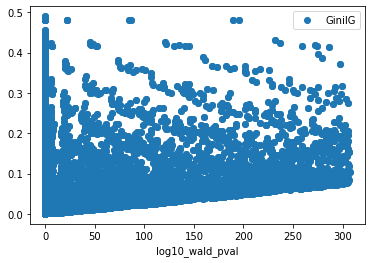

In [20]:
pdf.plot(x='log10_wald_pval', y='GiniIG', style='o')

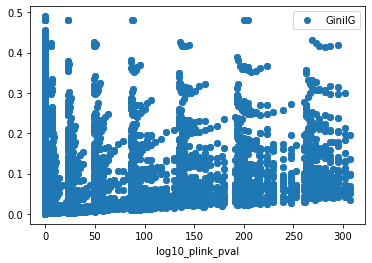

In [21]:
pdf.plot(x='log10_plink_pval', y='GiniIG', style='o')

# Pvalue vs Entropy

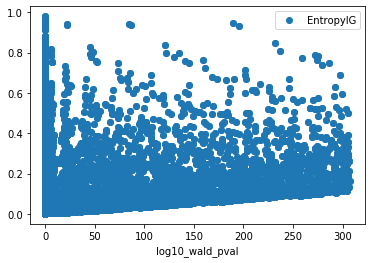

In [22]:
pdf.plot(x='log10_wald_pval', y='EntropyIG', style='o')

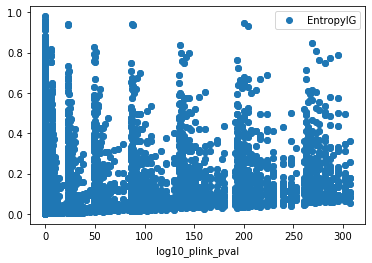

In [23]:
pdf.plot(x='log10_plink_pval', y='EntropyIG', style='o')

# Gini vs Entropy

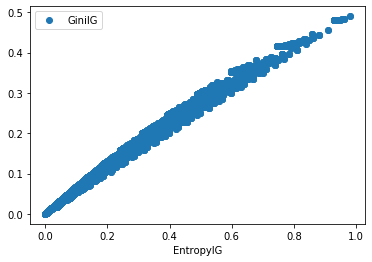

In [24]:
pdf.plot(x='EntropyIG', y='GiniIG', style='o')

# Pvalue vs Pvalue

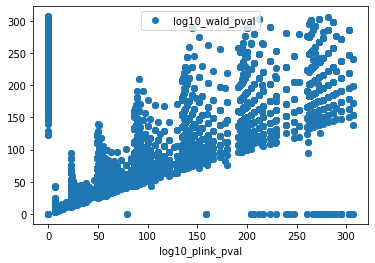

In [25]:
pdf.plot(x='log10_plink_pval', y='log10_wald_pval', style='o')

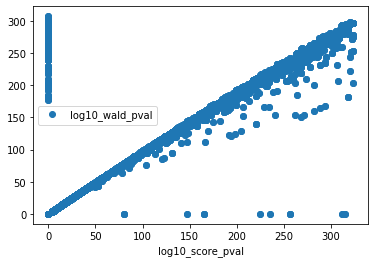

In [26]:
pdf.plot(x='log10_score_pval', y='log10_wald_pval', style='o')

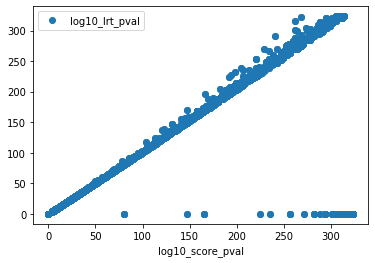

In [27]:
pdf.plot(x='log10_score_pval', y='log10_lrt_pval', style='o')

# Chi2 vs Chi2

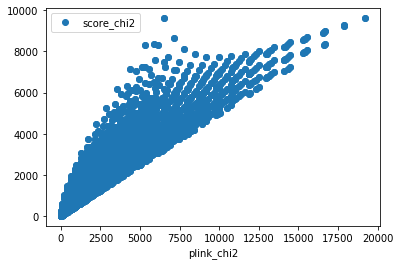

In [28]:
pdf.plot(x='plink_chi2', y='score_chi2', style='o')

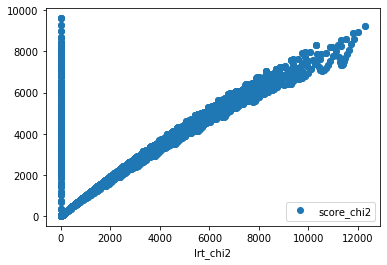

In [29]:
pdf.plot(x='lrt_chi2', y='score_chi2', style='o')

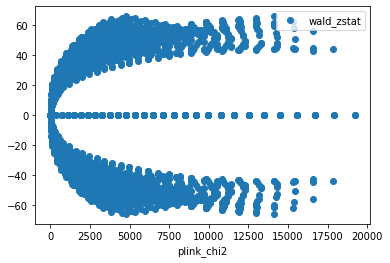

In [30]:
pdf.plot(x='plink_chi2', y='wald_zstat', style='o')

# Chi2 vs Gini

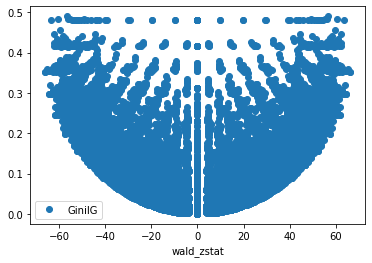

In [31]:
pdf.plot(x='wald_zstat', y='GiniIG', style='o')

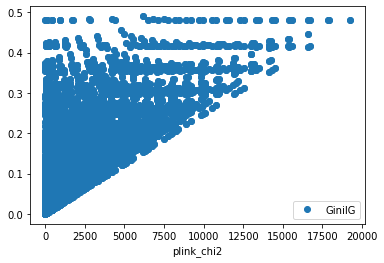

In [32]:
pdf.plot(x='plink_chi2', y='GiniIG', style='o')

# Chi2 vs Entropy

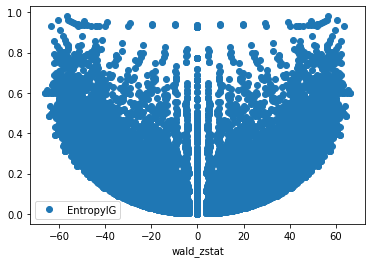

In [33]:
pdf.plot(x='wald_zstat', y='EntropyIG', style='o')

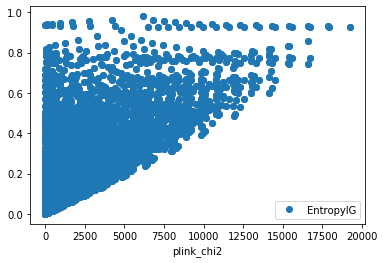

In [34]:
pdf.plot(x='plink_chi2', y='EntropyIG', style='o')